# Review - Principle Component Analysis
Taken from: http://sebastianraschka.com/Articles/2014_pca_step_by_step.html#eig_vec

### ToC


1. Introduction
    - Principal Component Analysis (PCA) Vs. Multiple Discriminant Analysis (MDA)
    - What is a “good” subspace?
    - Summarizing the PCA approach
2. Generating some 3-dimensional sample data
3. Taking the whole dataset ignoring the class labels
4. Computing the d-dimensional mean vector
5. Scarret and Covariance Matrices 
    - a) Computing the Scatter Matrix
    - b) Computing the Covariance Matrix (alternatively to the scatter matrix)
6. Computing eigenvectors and corresponding eigenvalues
    - Checking the eigenvector-eigenvalue calculation
    - Visualizing the eigenvectors
7. Eigenvectors
    - Sorting the eigenvectors by decreasing eigenvalues
    - Choosing k eigenvectors with the largest eigenvalues
8. Transforming the samples onto the new subspace
9. Using the PCA() class from the sklearn.decomposition library to confirm our results

# 1. Introduction

The main purposes of a principal component analysis are the analysis of data to **identify patterns and finding patterns to reduce the dimensions of the dataset with minimal loss of information.** Here, our desired outcome of the principal component analysis is to project a feature space (our dataset consisting of n d-dimensional samples) onto a smaller subspace that represents our data “well”. 

- PCA First it identifies the hyperplane that lies closest to the data, 
- and then it projects the data onto it. 
- Before you can project the training set onto a lower-dimensional hyperplane, you first need to choose the right hyperplane. 
- It seems reasonable to select the axis that preserves the maximum amount of variance, as it will most likely lose less information than the other projections. Another way to justify this choice is that it is the axis that minimizes the mean squared distance between the original dataset and its projection onto that axis. This is the rather simple idea behind PCA.

## Principal Component Analysis (PCA) Vs. Multiple Discriminant Analysis (MDA)
Both Multiple Discriminant Analysis (MDA) and Principal Component Analysis (PCA) are **linear transformation methods and closely related to each other.**
- **PCA:** In PCA we are interested to find the directions (components) that maximize the variance in our dataset, 
- **MDA:** where in MDA, we are additionally interested to find the directions that maximize the separation (or discrimination) between different classes (for example, in pattern classification problems where our dataset consists of multiple classes. In contrast two PCA, which ignores the class labels).

In other words, via PCA, **we are projecting the entire set of data (without class labels) onto a different subspace, and in MDA, we are trying to determine a suitable subspace to distinguish between patterns that belong to different classes.** Or, roughly speaking in PCA we are trying to find the axes with maximum variances where the data is most spread (within a class, since PCA treats the whole data set as one class), and in MDA we are additionally maximizing the spread between classes.

##### In typical pattern recognition problems, a PCA is often followed by an MDA.

## What is a “good” subspace?
Let’s assume that our goal is to reduce the dimensions of a d-dimensional dataset by projecting it onto a (k)-dimensional subspace (where k is less than d). So, how do we know what size we should choose for k, and how do we know if we have a feature space that represents our data “well”?

Later, we will compute **eigenvectors (the components)** from our data set and collect them in a so-called **scatter-matrix (or alternatively calculate them from the covariance matrix).** Each of those eigenvectors is associated with an eigenvalue, which tell us about the “length” or “magnitude” of the eigenvectors. 
- **If we observe that all the eigenvalues are of very similar magnitude,** this is a good indicator that our data is already in a “good” subspace. 
- If some of the eigenvalues are much much higher than others, we might be interested in keeping only those eigenvectors with the much larger eigenvalues, **since they contain more information about our data distribution.** 

**Vice versa, eigenvalues that are close to 0 are less informative and we might consider in dropping those when we construct the new feature subspace.**

## Summarizing the PCA approach

Listed below are the 6 general steps for performing a principal component analysis, which we will investigate in the following sections.
1. **Take X and ignore labels:** Take the whole dataset consisting of d-dimensional samples ignoring the class labels
2. **Compute means of each feature:** Compute the d-dimensional mean vector (i.e., the means for every dimension of the whole dataset)
3. **Compute the covariance matrix:** Compute the scatter matrix (alternatively, the covariance matrix) of the whole data set
4. **Comput eigenvalues:** Compute eigenvectors $(\pmb e_1, \; \pmb e_2, \; ..., \; \pmb e_d)$ and corresponding eigenvalues $(\pmb \lambda_1, \; \pmb \lambda_2, \; ..., \; \pmb \lambda_d)$
5. **Sort eigenvalues:** Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d×k dimensional matrix $W$(where every column represents an eigenvector)
6. **Project data onto new subspace:** Use this d×k eigenvector matrix to transform the samples onto the new subspace. This can be summarized by the mathematical equation: $\pmb y = \pmb W^T \times \pmb x$ (where x is a d×1-dimensional vector representing one sample, and y is the transformed k×1-dimensional sample in the new subspace.)

# 2. Generating some 3-dimensional sample data
For the following example, we will generate 40-3 dimentional samples randomly, drawn from a multivariate Guassian distribution. Here we will assume that the samples stem from two different classes, where one half (20 samples) of our dataset are labelled w1 and the other w2 (class 1 and 2).

Using the code below, we create two 3×20 datasets - one dataset for each class ω1 and ω2 - where each column can be pictured as a 3-dimensional vector $\pmb x = \begin{pmatrix} x_1 \\ x_2 \\ x_3 \end{pmatrix}$ so that our dataset will have the form
$\pmb X = \begin{pmatrix} x_{1_1}\; x_{1_2} \; ... \; x_{1_{20}}\\ x_{2_1} \; x_{2_2} \; ... \; x_{2_{20}}\\ x_{3_1} \; x_{3_2} \; ... \; x_{3_{20}}\end{pmatrix}$

Populating the interactive namespace from numpy and matplotlib


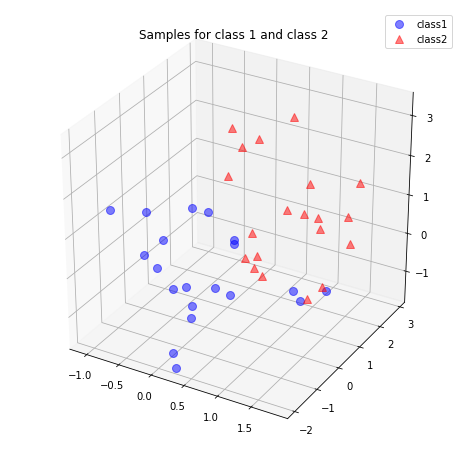

In [108]:
%pylab inline
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
import numpy as np

#create data
np.random.seed(42) # random seed for consistency

mu_vec1 = np.array([0,0,0])
cov_mat1 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class1_sample = np.random.multivariate_normal(mu_vec1, cov_mat1, 20).T
assert class1_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

mu_vec2 = np.array([1,1,1])
cov_mat2 = np.array([[1,0,0],[0,1,0],[0,0,1]])
class2_sample = np.random.multivariate_normal(mu_vec2, cov_mat2, 20).T
assert class2_sample.shape == (3,20), "The matrix has not the dimensions 3x20"

#plot data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
plt.rcParams['legend.fontsize'] = 10   
ax.plot(class1_sample[0,:], class1_sample[1,:], class1_sample[2,:], 'o', markersize=8, color='blue', alpha=0.5, label='class1')
ax.plot(class2_sample[0,:], class2_sample[1,:], class2_sample[2,:], '^', markersize=8, alpha=0.5, color='red', label='class2')

plt.title('Samples for class 1 and class 2')
ax.legend(loc='upper right')

plt.show()

# 3. Taking the whole data and ignoring the class
Because we don't need class labels for the PCA analysis, lets merge the samples for our two classes.

In [109]:
all_samples = np.concatenate((class1_sample, class2_sample),axis=1)
assert all_samples.shape==(3,40), "The matrix does not have the dimensions 3x40"

print(all_samples.shape)
print(all_samples[0])

(3, 40)
[ 0.49671415  1.52302986  1.57921282  0.54256004  0.24196227 -0.56228753
 -0.90802408 -0.2257763  -0.54438272  0.37569802 -0.60170661 -1.05771093
  0.2088636   0.19686124 -0.11564828 -0.71984421  0.34361829 -0.38508228
  1.03099952 -0.30921238  0.52082576 -0.19620662  0.92798988  0.35488025
  0.96417396  1.8219025   1.09176078  1.35711257  0.1915064   1.32875111
  1.09707755  0.67233785  1.29612028  0.76541287  0.65728548  1.40405086
  1.25755039  0.97348612  0.80763904 -0.16867804]


# 4. Computing the d-dimensionarl mean vector

In [110]:
mean_x = np.mean(all_samples[0,:])
mean_y = np.mean(all_samples[1,:])
mean_z = np.mean(all_samples[2,:])

mean_vector = np.array([[mean_x], [mean_y], [mean_z]])
print(mean_vector)

[[ 0.45587059]
 [ 0.46810083]
 [ 0.33852142]]


# 5. a) Computing the Scatter Matrix

The scatter matrix is computed by the following equation:
$S = \sum\limits_{k=1}^n (\pmb x_k - \pmb m)\;(\pmb x_k - \pmb m)^T$

where **m** is the mean vector: $\pmb m = \frac{1}{n} \sum\limits_{k=1}^n \; \pmb x_k$

In [111]:
scatter_matrix = np.zeros((3,3))
scatter_matrix

array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])

In [112]:
#do this calc and sum for all oberservations to get the scatter matrix
#x-m
samp = all_samples[:,1].reshape(3,1) - mean_vector
# 3x1.dot(1x3) = 3x3 matrix
samp.dot(samp.T)

array([[ 1.13882891, -0.74941709, -0.61111769],
       [-0.74941709,  0.49316097,  0.40215175],
       [-0.61111769,  0.40215175,  0.32793761]])

In [113]:
#initialize
scatter_matrix = np.zeros((3,3))

#loop through each of the 20 observations
for i in range(all_samples.shape[1]):
    samp = all_samples[:,i].reshape(3,1) - mean_vector
    scatter_matrix += samp.dot(samp.T)
    
scatter_matrix

array([[ 22.16567148,  12.53976465,   2.79387084],
       [ 12.53976465,  60.31432017,  16.34412085],
       [  2.79387084,  16.34412085,  58.05790884]])

# 5. b) Computing the Covariance Matrix (alternative to scatter matrix)

Instead of calculating the scatter matrix, we could also calculate the covariance matrix using the built-in numpy.cov() funciton. The equations for the covariance matrix and scatter matrix are very similar, the **only difference is that we use the scaling factor $\frac{1}{N-1}$ (here: $\frac{1}{40-1} = \frac{1}{39}$) for the covariance matrix.**

Thus, their **eigenspaces will be identical (because we are only scaling the vectors, not changing the direction!!!)**: 

$% <![CDATA[
\Sigma_i = \Bigg[
\begin{array}{cc}
\sigma_{11}^2 & \sigma_{12}^2 & \sigma_{13}^2\\
\sigma_{21}^2 & \sigma_{22}^2 & \sigma_{23}^2\\
\sigma_{31}^2 & \sigma_{32}^2 & \sigma_{33}^2\\
\end{array} \Bigg] %]]>$

#### As we can see from the code below, adding the scaling factor to our scatter matrix code produces the same results as the np.cov() function

In [114]:
covariance_matrix = np.cov([all_samples[0,:],all_samples[1,:],all_samples[2,:]])
print('Covariance Matrix using np.cov():\n', covariance_matrix,"\n")

#initialize
custom_cov_matrix = np.zeros((3,3))
#loop through each of the 20 observations
for i in range(all_samples.shape[1]):
    samp = all_samples[:,i].reshape(3,1) - mean_vector
    scaling_factor = 1/(all_samples.shape[1]-1)
    custom_cov_matrix += samp.dot(samp.T) * scaling_factor #add scaling factor to make it covariance matrix
    
print('Covariance Matrix using custom covariance calc:\n', custom_cov_matrix)


Covariance Matrix using np.cov():
 [[ 0.56835055  0.32153243  0.07163771]
 [ 0.32153243  1.54652103  0.41908002]
 [ 0.07163771  0.41908002  1.48866433]] 

Covariance Matrix using custom covariance calc:
 [[ 0.56835055  0.32153243  0.07163771]
 [ 0.32153243  1.54652103  0.41908002]
 [ 0.07163771  0.41908002  1.48866433]]


# 6. Computing eigenvectors and corresponding eigenvalues

To show that the eigenvectors are indeed identical wheather we derived them from the scatter or the covariance matrix, we will put an assert funciton into the code below. We will also see that the eigenvalues were indeed scalled by a factor of 39.

### SIDENOTE on EIGENVECTORS:

An **eigenvector** of a square matrix $M$ (also called a **characteristic vector**) is a non-zero vector that remains on the same line after transformation by the linear transformation associated with $M$. A more formal definition is any vector $v$ such that:

$M \cdot v = \lambda \times v$

Where $\lambda$ is a scalar value called the **eigenvalue** associated to the **eigenvector of M** $v$.

For example, any horizontal vector remains horizontal after applying the shear mapping (as you can see on the image below), so it is an eigenvector of $M$. A vertical vector ends up tilted to the right, so vertical vectors are *NOT* eigenvectors of $M$.

#### NumPy's `eig` function returns the list of unit eigenvectors and their corresponding eigenvalues for any square matrix.

In [115]:
F_squeeze = np.array([[1.4,0.],[ 0.,0.71428571]])
eigenvalues, eigenvectors = np.linalg.eig(F_squeeze)
print('F_squeeze:\n', F_squeeze)
print('Eigenvectors:\n', eigenvectors)
print('Eigenvalues:\n', eigenvalues)
#eigenvalues # [λ0, λ1, …]

F_squeeze:
 [[ 1.4         0.        ]
 [ 0.          0.71428571]]
Eigenvectors:
 [[ 1.  0.]
 [ 0.  1.]]
Eigenvalues:
 [ 1.4         0.71428571]


#### Back to the task at hand!

In [116]:
# eigenvectors and eigenvalues for the from the scatter matrix
eig_val_sc, eig_vec_sc = np.linalg.eig(scatter_matrix)

# eigenvectors and eigenvalues for the from the covariance matrix
eig_val_cov, eig_vec_cov = np.linalg.eig(covariance_matrix)

for i in range(len(eig_val_sc)):
    eigvec_sc = eig_vec_sc[:,i].reshape(1,3).T
    eigvec_cov = eig_vec_cov[:,i].reshape(1,3).T
    assert eigvec_sc.all() == eigvec_cov.all(), 'Eigenvectors are not identical'
    print('The Eigenvectors are the exact same!!! Woooot')
    print('Remember, there is one eigenvector per column of matrix M!!!!!!\n')
    print('Eigenvector {}: \n{}'.format(i+1, eigvec_sc))
    print('Eigenvalue {} from scatter matrix: {}'.format(i+1, eig_val_sc[i]))
    print('Eigenvalue {} from covariance matrix: {}'.format(i+1, eig_val_cov[i]))
    print('Scaling factor: ', eig_val_sc[i]/eig_val_cov[i])
    print(40 * '-')

The Eigenvectors are the exact same!!! Woooot
Remember, there is one eigenvector per column of matrix M!!!!!!

Eigenvector 1: 
[[-0.19917457]
 [-0.74116832]
 [-0.64109204]]
Eigenvalue 1 from scatter matrix: 77.8213933842646
Eigenvalue 1 from covariance matrix: 1.9954203431862738
Scaling factor:  39.0
----------------------------------------
The Eigenvectors are the exact same!!! Woooot
Remember, there is one eigenvector per column of matrix M!!!!!!

Eigenvector 2: 
[[-0.95000993]
 [ 0.30654625]
 [-0.05924975]]
Eigenvalue 2 from scatter matrix: 18.293626039055113
Eigenvalue 2 from covariance matrix: 0.4690673343347471
Scaling factor:  39.0
----------------------------------------
The Eigenvectors are the exact same!!! Woooot
Remember, there is one eigenvector per column of matrix M!!!!!!

Eigenvector 3: 
[[-0.2404384 ]
 [-0.59724276]
 [ 0.76517348]]
Eigenvalue 3 from scatter matrix: 44.42288106224649
Eigenvalue 3 from covariance matrix: 1.1390482323652946
Scaling factor:  39.0
---------

### Checking the eigenvector-eigenvalue calculation

Let us quickly cehck that the eighvector-eigenvalue calc is correct and satisfies the equation:

$$\pmb\Sigma\pmb{v} = \lambda\pmb{v}$$

Where:

$\pmb\Sigma = Covariance \; matrix\\
\pmb{v} = \; Eigenvector\\
\lambda = \; Eigenvalue$

In [117]:
#check to see if they formula holds!!!
for i in range(len(eig_val_sc)):
    eig = eig_vec_sc[:,i]
    eig_val = eig_val_sc[i]
    print(scatter_matrix.dot(eig))
    print(eig*eig_val)

[-15.50004287 -57.6787516  -49.89067601]
[-15.50004287 -57.6787516  -49.89067601]
[-17.37912639   5.60784238  -1.08389278]
[-17.37912639   5.60784238  -1.08389278]
[-10.6809663  -26.53124419  33.99121067]
[-10.6809663  -26.53124419  33.99121067]


In [118]:
#do the same thing with an assert function!!!
for i in range(len(eig_val_sc)):
    eig = eig_vec_sc[:,i]
    eig_val = eig_val_sc[i]
    np.testing.assert_array_almost_equal(scatter_matrix.dot(eig), 
                                         eig*eig_val,
                                        decimal=6, err_msg="YOU SUCK",
                                            verbose=True)
    print("Eig {} matches!".format(i))

Eig 0 matches!
Eig 1 matches!
Eig 2 matches!


### Visualizing the eigenvectors

And before we move on, lets also plot the eigenvectors centered at the sample mean!!!

Populating the interactive namespace from numpy and matplotlib


C:\Users\mciniello\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['eig']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


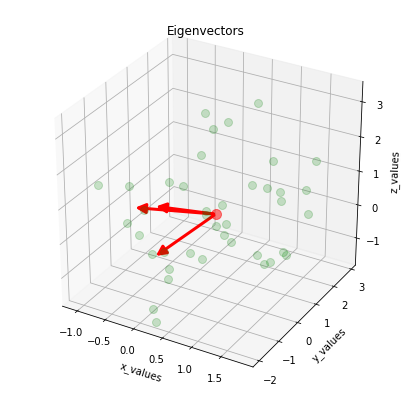

In [119]:
%pylab inline

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from matplotlib.patches import FancyArrowPatch


class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

ax.plot(all_samples[0,:], all_samples[1,:], all_samples[2,:], 'o', markersize=8, color='green', alpha=0.2)
ax.plot([mean_x], [mean_y], [mean_z], 'o', markersize=10, color='red', alpha=0.5)
for v in eig_vec_sc.T:
    a = Arrow3D([mean_x, v[0]], [mean_y, v[1]], [mean_z, v[2]], mutation_scale=20, lw=3, arrowstyle="-|>", color="r")
    ax.add_artist(a)
ax.set_xlabel('x_values')
ax.set_ylabel('y_values')
ax.set_zlabel('z_values')

plt.title('Eigenvectors')

plt.show()

# 7. Eigenvectors

## Sorting eigenvectors by decreasing eigenvalues

We started with the goal to reduce the dimensionality of our feature space, i.e., projecting the feature space via PCA onto a smaller subspace, **where the eigenvectors will form the axes of this new feature subspace.** 

However the eigenvectors only define the directions of the new axis, since they have all the same unit legnth 1, which we can confirm by the following code:

In [120]:
for ev in eig_vec_sc:
    print('Eigenvector: ', ev, 'Norm: ', np.linalg.norm(ev))

Eigenvector:  [-0.19917457 -0.95000993 -0.2404384 ] Norm:  1.0
Eigenvector:  [-0.74116832  0.30654625 -0.59724276] Norm:  1.0
Eigenvector:  [-0.64109204 -0.05924975  0.76517348] Norm:  1.0


So, in order to decide which eigenvector(s) we want to drop for our lower-dimensional subspace,** we have to take a look at the corresponding eigenvalues of the eigenvectors.** 

### Roughly speaking, the eigenvectors with the lowest eigenvalues bear the least information about the distribution of the data, and those are the ones we want to drop. The common approach is to rank the eigenvectors from highest to lowest corresponding eigenvalue and choose the top k eigenvectors.

In [121]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_val_sc[i]), eig_vec_sc[:,i]) for i in range(len(eig_val_sc))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(key=lambda x: x[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues
for i in eig_pairs:
    print(i[0])

77.8213933843
44.4228810622
18.2936260391


## Choosing k eigenvectors with the largest eigenvalues
For our simple example, where we are reducing a 3-dimensional feature space to a 2-dimensional feature subspace, we are combining the two eigenvectors with the highest eigenvalues to construct our d×k-dimensional eigenvector matrix W.

#### Remember from HOML, ordering the eigenvectors by eigenvalue and chosing the top k eigenvectors allows us to preserve the a specified amount of variance in the original data (variance is information!!!).

In [122]:
#print out the top 2 eignvectors which
matrix_w = np.hstack((eig_pairs[0][1].reshape(3,1), eig_pairs[1][1].reshape(3,1)))
print('Matrix W:\n', matrix_w)



Matrix W:
 [[-0.19917457 -0.2404384 ]
 [-0.74116832 -0.59724276]
 [-0.64109204  0.76517348]]


# 8. Transforming the samples onto the new subspace

In the last step, we use the 2 x 3-dimenstional matrix W thta we just computed to transform out samples onto the new subspace via the equation $\pmb y = \pmb W^T \times \pmb x$

(2, 40)


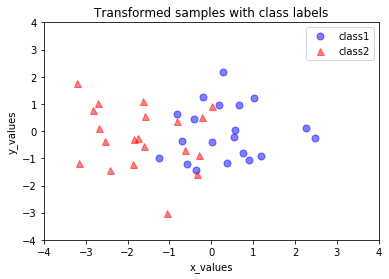

In [123]:
transformed = matrix_w.T.dot(all_samples)
print(transformed.shape)

plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples with class labels')

plt.show()

# 9. Using the PCA() class from the sklean.decomposition library to confirm our results

We will now try this with the PCA class from scikit-learn ML library. We will want to reduce out input to 2 dimensions using the n_components parameter.

For more info, check out the documentation: http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html.

n_components : int, None or string

        Number of components to keep. if n_components is not set all components are kept:
            n_components == min(n_samples, n_features)
            if n_components == ‘mle’, Minka’s MLE is used to guess the dimension if 0 < n_components < 1,
            select the number of components such that the amount of variance that needs to be explained
            is greater than the percentage specified by n_components



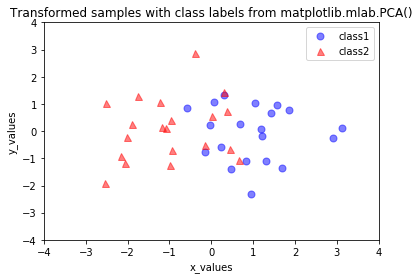

In [124]:
from sklearn.decomposition import PCA as sklearnPCA

sklearn_pca = sklearnPCA(n_components=2)
sklearn_transf = sklearn_pca.fit_transform(all_samples.T)

plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples with class labels from matplotlib.mlab.PCA()')

plt.show()

**The plot above seems to be the exact MIRROR IMAGE of the plot from out step by step approach. This is due to the fact that the signs of the eigenvectors can be either positive or negative, since the eigenvectors are scaled to the unit length 1, both we can simply multiply the transformed data by ×(−1) to revert the mirror image.**

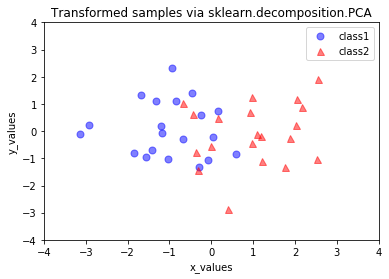

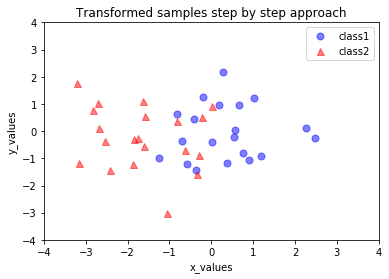

In [125]:
sklearn_transf = sklearn_transf * (-1)

# sklearn.decomposition.PCA
plt.plot(sklearn_transf[0:20,0],sklearn_transf[0:20,1], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(sklearn_transf[20:40,0], sklearn_transf[20:40,1], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.legend()
plt.title('Transformed samples via sklearn.decomposition.PCA')
plt.show()

# step by step PCA
plt.plot(transformed[0,0:20], transformed[1,0:20], 'o', markersize=7, color='blue', alpha=0.5, label='class1')
plt.plot(transformed[0,20:40], transformed[1,20:40], '^', markersize=7, color='red', alpha=0.5, label='class2')
plt.xlim([-4,4])
plt.ylim([-4,4])
plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.title('Transformed samples step by step approach')
plt.show()